In [146]:
import cProfile
import os
import pickle
import pstats
import re
import time
from collections import namedtuple, defaultdict
from typing import List
from multiprocessing import Pool
import networkx as NX
import pandas as pds
import matplotlib.pyplot as plt
import itertools
import math
import re
import statistics
from pprint import pprint

import rich.progress
import scipy
from scipy import stats as scistats
from sklearn import linear_model, preprocessing
from tabulate import tabulate
from pathlib import Path
import pickle
import random
import argparse
import sys

import data_types
from db_actions import db_actions
import numpy as np
from my_yaml import yaml_load, yaml_dump
from alive_progress import alive_bar
import seaborn as sns
from data_types import PickleOut
import commons
import rich.status
from rich.pretty import pprint
from rich import inspect


In [2]:
rc = commons.rc

In [3]:
TR = namedtuple('TableRow', ["cluster", "wfName", "method", "res"])
BigTR = namedtuple("BigTableRow", ["regModel", "cluster", "clusterSize", "wfName", "method", "res", "schedCat", "schedType"])
CVBigTR = namedtuple("CVBigTableRow", ["regModel", "cluster", "clusterSize", "wfName", "method", "res", "schedCat", "schedType", "cvSplit"])
CVUBigTR = namedtuple("CVUBigTableRow", [
    "regModel",
    "cluster",
    "clusterSize",
    "wfName",
    "method",
    "res",
    #"schedCat",
    #"schedType",
    "cvSplit",
    "ukSplit"])

In [188]:
shortToLongNameLUT = {'Linear'       : 'Ordinary Least Squares',
                      'SVR-linear'   : 'SVR - linear',
                      'SVR-poly'     : 'SVR - poly',
                      'SVR-rbf'      : 'SVR - rbf',
                      'SVR-sigmoid'  : 'SVR - sigmoid',
                      'Lasso'        : 'Lasso',
                      'LassoCV'      : 'Lasso CV',
                      'Ridge'        : 'Ridge',
                      'RidgeCV'      : 'Ridge CV',
                      'ElasticNet'   : 'Elastic Net',
                      'ElasticNetCV' : 'Elastic Net CV',
                      'BayesianRidge': 'Bayesian Ridge',
                      'ARD'          : 'Automatic Relevance Determination',
                      'SGD'          : 'Stochastic Gradient Descent',
                      'PA'           : 'Passive Aggressive',
                      'Huber'        : 'Huber',
                      'TheilSen'     : 'Theil Sen'}

In [4]:
def load_from_file(f, prog: rich.progress.Progress, barid):
    modelDegLUT = {
        'linModel' : 1,
        'quadModel': 2,
        'cubeModel': 3,
        'tetModel' : 4,
        'penModel' : 5
    }
    shorterMethodNamesLUT = {
        'randomScheduler'     : 'random',
        'recommenderScheduler': 'recommender'
    }
    pFile = Path(f)
    with open(pFile, "br") as tmp:
        pl: dict = pickle.load(tmp)
    #
    m = re.match("(?:.*/)*(.*Model)\.(.*)_CV-(.*)_U-(.*)\.recSchedTimes\.pickle", f)
    modelDeg = modelDegLUT[m.group(1)]
    modelName = shortToLongNameLUT[m.group(2)]
    shortName = f"{modelDeg} / {modelName}"
    cvSplit = m.group(3)
    if cvSplit == "None":
        cvSplit = None
    ukSplit = m.group(4)
    if ukSplit == "None":
        ukSplit = None
    # for pre, deg in modelDegLUT.items():
    #     if pre in shortName:
    #         shortName = shortName.replace(pre + ".", f"{deg}/")
    #         break
    fmt = CVUBigTR
    #
    prog.reset(barid, total=len(pl.items()))
    for clusterName, cluster in pl.items():
        for wfName, wf in cluster.items():
            wfShortName = re.match("nfcore/(.*):.*", wfName).group(1)
            for methodName, res in wf.items():
                for longN, rep in shorterMethodNamesLUT.items():
                    if longN in methodName:
                        mName = methodName.replace(longN, rep)
                        break
                rowInfo = {
                    "regModel"   : shortName,
                    "cluster"    : str(clusterName),
                    "clusterSize": len(clusterName),
                    "wfName"     : wfShortName,
                    "method"     : mName,
                    #"schedCat"   : "recommenderV1,-H1,-H2,-H3" if "V1" in mName else "recommenderV2,-H1,-H2,-H3",
                    #"schedType"  : mName,
                    "cvSplit"    : cvSplit,
                    "ukSplit"    : ukSplit
                }
                if type(res) != list:
                    rowInfo["res"] = float(res)
                    yield fmt(**rowInfo)
                # else:
                #     rowInfo["regModel"] = "N/A"
                #     rowInfo["schedCat"] = "random"
                #     rowInfo["schedType"] = "random"
                #     randomPs = [1, 2, 3]
                #     for i, r in enumerate(res):  # this only applies to the results of the randomScheduler(V1)
                #         if i + 1 in randomPs:
                #             rowInfo["method"] = mName + f"P{i * 10}"
                #             rowInfo["res"] = float(r)
                #             yield fmt(**rowInfo)
                #     rowInfo["method"] = mName + "Avg"
                #     rowInfo["res"] = float(statistics.mean(res))
                #     yield fmt(**rowInfo)
        prog.advance(barid)
    del pl


def load_random_from_files(d, prog: rich.progress.Progress, barid):
    if type(d) is str:
        d = Path(d)
    #
    refFile = d.joinpath(os.listdir(d)[0])
    with open(refFile, "br") as tmp:
        refP: dict = pickle.load(tmp)
    #
    fmt = CVUBigTR
    cls = list(refP.keys())
    wfs = list(refP[cls[0]].keys())
    del refP
    prog.reset(barid, total=len(cls) * len(wfs))
    pls = list()
    for fName in os.listdir(d):
        pFile = d.joinpath(fName)
        with open(pFile, "br") as tmp:
            pl: dict = pickle.load(tmp)
        for clusterName, cluster in pl.items():
            for wfName, wf in cluster.items():
                for methodName in list(wf.keys()):
                    if not "random" in methodName:
                        del pl[clusterName][wfName][methodName]
        #
        pls.append(pl)
        del pl
    for clusterName in cls:
        for wfName in wfs:
            wfShortName = re.match("nfcore/(.*):.*", wfName).group(1)
            #
            randoms = [x for pl in pls for x in pl[clusterName][wfName]["randomSchedulerV1"]]
            for pl in pls:
                del pl[clusterName][wfName]
            randoms.sort()
            indices = [int(round(len(randoms) - 1 - x * (len(randoms) - 1), 0)) for x in [a / 10 for a in range(0, 11)]]
            randoms = [x for i, x in enumerate(randoms) if i in indices]
            rowInfo = {
                "regModel"   : "N/A",
                "cluster"    : str(clusterName),
                "clusterSize": len(clusterName),
                "wfName"     : wfShortName,
                "method"     : "randomV1",
                #"schedCat"   : "random",
                #"schedType"  : "random",
                "cvSplit"    : "N/A",
                "ukSplit"    : "N/A"
            }
            for i, r in enumerate(randoms):  # this only applies to the results of the randomScheduler(V1)
                rowInfo["method"] = f"randomV1P{i * 10}"
                rowInfo["res"] = float(r)
                yield fmt(**rowInfo)
            rowInfo["method"] = "randomV1Avg"
            rowInfo["res"] = float(statistics.mean(randoms))
            yield fmt(**rowInfo)
            prog.advance(barid)


def load_from_dir(d):
    with commons.stdProgress(rc) as prog:
        # with alive_bar(len(os.listdir(d)), f"Loading recommenderScheduler results from {d}") as bar:
        fileProg = prog.add_task("Files", total=len(os.listdir(d)))
        clusterProg = prog.add_task("Clusters")
        for f in os.listdir(d):
            yield from load_from_file(f"{d}/{f}", prog, clusterProg)
            prog.advance(fileProg)
        randomsProg = prog.add_task("Randoms")
        yield from load_random_from_files(d, prog, randomsProg)

In [5]:
def get_bigtable(saveLoc, btFileLoc):
    btFile = Path(btFileLoc)
    if not btFile.is_file():
        bigtable = pds.DataFrame(load_from_dir(saveLoc), columns=CVUBigTR._fields)
        with open(btFile, "bw") as f:
            pickle.dump(bigtable, f)
    else:
        with open(btFile, "br") as f:
            bigtable = pickle.load(f)
    return bigtable

In [111]:
def save_plot(obj, name, loc="./fig/", **kwargs):
    obj.savefig(f"{loc}{name}.pdf", transparent=True, **kwargs)
    obj.savefig(f"{loc}{name}.png", transparent=True, **kwargs)

# Get the recSchedTimes data

In [7]:
bigtable = get_bigtable("recSchedTimes", "./recSchedBigTable.pickle")  #.sample(frac=5 / 100, random_state=0, axis=0)
# bigtable

# Get the cvRecSchedTimes data

In [8]:
cvBigtable = get_bigtable("cvRecSchedTimes", "./cvRecSchedBigTable.pickle")  #.sample(frac=5 / 100, random_state=0, axis=0)
# cvBigtable

In [9]:
wfNames = bigtable.wfName.unique()

In [10]:
sns.set_theme(style="whitegrid")
#sns.set_context("paper")
sns.set_context("paper", 1.65)

In [11]:
pds.set_option('display.max_rows', 100)
pds.set_option('display.max_columns', None)
pds.set_option('display.width', None)
pds.set_option('display.precision', 4)


# trying out new visualisation

In [12]:
rc.print(bigtable.cluster.unique())
rc.print(len(bigtable.cluster.unique()))

['(166, 171, 173, 175, 178, 179, 180, 182, 182, 183, 185, 191, 192, 193)'
 '(167, 168, 168, 169, 169, 169, 173, 175, 175, 184, 186, 186, 188, 189, 190, 191, 192, 192)'
 '(168, 171, 176, 178, 180, 181, 182, 182, 184, 184, 186, 187)' ...
 '(165, 165, 170, 171, 171, 171, 172, 175, 179, 179, 180, 180, 181, 184, 191, 191, 193)'
 '(172, 172, 175, 183, 184, 185, 186, 186, 188, 188, 189, 190, 192, 192, 192)'
 '(178, 181, 181, 182, 183, 184, 185, 185, 187, 190)']

10000

In [170]:
tmp = bigtable[bigtable.regModel != "N/A"]
clusters = tmp.cluster.unique()
regModels = tmp.regModel.unique()
methods = tmp.method.unique()
del tmp

In [198]:
confs = dict()
with open("percentileModels","r") as f:
    for fName in f:
        with open(fName.strip(), "br") as f2:
            l:PickleOut = pickle.load(f2)
            m = re.match("(?:.*/)*(.*)\.(.*)_CV-(.*)_U-(.*).pickle",fName.strip())
            confs[f"{l.polyDeg} / {shortToLongNameLUT[m.group(2)]}"] = commons.jamGeomean([l.train_confidence, l.test_confidence, l.full_confidence])
            

In [203]:
confs

{
│   '5 / Ordinary Least Squares': 1.0,
│   '3 / Ridge': 0.9231538458419148,
│   ... +9
}

In [204]:
regModels = sorted(regModels, key=lambda x: confs[x], reverse=True)

In [205]:
pprint(regModels)

[
│   '5 / Ordinary Least Squares',
│   '3 / Ridge',
│   '3 / SVR - linear',
│   '3 / Elastic Net CV',
│   '2 / Ridge CV',
│   '1 / Ordinary Least Squares',
│   '1 / Lasso CV',
│   '1 / SVR - linear',
│   '3 / Elastic Net',
│   '1 / Elastic Net',
│   '4 / Passive Aggressive'
]

In [206]:
def getRegModelMethodScores(fileLoc: Path, table, crit=None, scorer=None, tol=1):
    if crit is None:
        def yep (cur, mini, tol): 
            return abs(cur-mini)<=tol
        crit = yep
    if scorer is None:
        def sc(cur, mini, tol):
            return 1
        scorer = sc
    if type(fileLoc) is str:
        fileLoc = Path(fileLoc)
    if fileLoc.is_file():
        with open(fileLoc, "br") as f:
            return pickle.load(f)
    else:
        grouped = table[table.regModel != "N/A"].pivot(["cluster", "wfName", "regModel"], "method", "res")
        clWFCombs = itertools.product(clusters, wfNames)
        numclWFCombs = len(list(clWFCombs))
        clWFCombs = itertools.product(clusters, wfNames)
        rMMethCombs = list(itertools.product(regModels, methods))
        # regModelMethodScores = defaultdict(lambda: 0)
        with commons.stdProgress(rc) as prog:
            cvwfProg = prog.add_task("Cluster/Workflow", total=numclWFCombs)
            regModelMethodScores = defaultdict(lambda: 0)

            for clwf, subtable in grouped.groupby(level=(0, 1), group_keys=False):
                c, wf = clwf
                subtable = subtable.droplevel(["cluster", "wfName"])
                minimumTime = subtable.min().min()
                for rmmetch in rMMethCombs:
                    rM, meth = rmmetch
                    # rc.log(subtable.loc[rM, meth], minimumTime, abs(subtable.loc[rM, meth] - minimumTime), abs(subtable.loc[rM, meth] - minimumTime) <= tol)
                    curr= subtable.loc[rM, meth]
                    if type(tol) is int or type(tol) is float:
                        t= tol
                    else:
                        t = tol(curr, minimumTime)
                    if crit(curr, minimumTime, t):
                        regModelMethodScores[rmmetch] = regModelMethodScores[rmmetch] + scorer(curr, minimumTime, t)
                prog.advance(cvwfProg)
            regModelMethodScores = dict(regModelMethodScores)
        #
        with open(fileLoc, "bw") as f:
            pickle.dump(regModelMethodScores, f)
        return dict(regModelMethodScores)

In [235]:
with rich.status.Status("Processing"):
    t = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["cvSplit", "ukSplit"])
yep = None
for i in t:
    yep = i
    break
yep


Output()

(
│   (
│   │   'chipseq',
│   │   'eager'
│   ),
│   │   │   │      regModel                                            cluster  \
4400000   3 / SVR - rbf  (166, 171, 173, 175, 178, 179, 180, 182, 182, ...   
4400001   3 / SVR - rbf  (166, 171, 173, 175, 178, 179, 180, 182, 182, ...   
4400002   3 / SVR - rbf  (166, 171, 173, 175, 178, 179, 180, 182, 182, ...   
4400003   3 / SVR - rbf  (166, 171, 173, 175, 178, 179, 180, 182, 182, ...   
4400004   3 / SVR - rbf  (166, 171, 173, 175, 178, 179, 180, 182, 182, ...   
...                 ...                                                ...   
20399995  1 / SVR - rbf  (178, 181, 181, 182, 183, 184, 185, 185, 187, ...   
20399996  1 / SVR - rbf  (178, 181, 181, 182, 183, 184, 185, 185, 187, ...   
20399997  1 / SVR - rbf  (178, 181, 181, 182, 183, 184, 185, 185, 187, ...   
20399998  1 / SVR - rbf  (178, 181, 181, 182, 183, 184, 185, 185, 187, ...   
20399999  1 / SVR - rbf  (178, 181, 181, 182, 183, 184, 185, 185, 187, ...   
│   │     
│   │     clusterSize      wfName           method          res  cvSplit  \
4400000            14       sarek    recommenderV1   41102.6000  chipseq   
4400001            14       sarek  recommenderV1H1   41102.6000  chipseq   
4400002            14       sarek  recommenderV1H2   41102.6000  chipseq   
4400003            14       sarek  recommenderV1H3   41102.6000  chipseq   
4400004            14       sarek    recommenderV2   41102.6000  chipseq   
...               ...         ...              ...          ...      ...   
20399995           10  viralrecon  recommenderV1H3  188586.2000  chipseq   
20399996           10  viralrecon    recommenderV2  147986.2000  chipseq   
20399997           10  viralrecon  recommenderV2H1  192919.5333  chipseq   
20399998           10  viralrecon  recommenderV2H2  192919.5333  chipseq   
20399999           10  viralrecon  recommenderV2H3  193119.5333  chipseq   
│   │    
│   │    ukSplit  
4400000    eager  
4400001    eager  
4400002    eager  
4400003    eager  
4400004    eager  
...          ...  
20399995   eager  
20399996   eager  
20399997   eager  
20399998   eager  
20399999   eager  

[1200000 rows x 8 columns]
)

In [207]:
regModelMethodScores = getRegModelMethodScores("regModelMethodScores.pickle", bigtable)

In [238]:
tmp = cvBigtable[cvBigtable.regModel != "N/A"]
clusters = tmp.cluster.unique()
regModels = tmp.regModel.unique()
methods = tmp.method.unique()
del tmp

In [239]:
confs = dict()
with open("percentileCVModels","r") as f:
    for fName in f:
        with open(fName.strip(), "br") as f2:
            l:PickleOut = pickle.load(f2)
            m = re.match("(?:.*/)*(.*)\.(.*)_CV-(.*)_U-(.*).pickle",fName.strip())
            confs[f"{l.polyDeg} / {shortToLongNameLUT[m.group(2)]}"] = commons.jamGeomean([l.train_confidence, l.test_confidence, l.full_confidence])
            

In [240]:
confs

{
│   '1 / SVR - rbf': 0.8402348354382618,
│   '1 / Stochastic Gradient Descent': 0.7747835078751857,
│   ... +1
}

In [241]:
regModels = sorted(regModels, key=lambda x: confs[x], reverse=True)

In [ ]:
cvScores = dict()
cv10PScores = dict()
for i, d in cvBigtable[cvBigtable.regModel != "N/A"].groupby(["cvSplit","ukSplit"]):
    cvScores[i] = getRegModelMethodScores(f"cvRegModelMethodScores_CV-{i[0]}_U-{i[1]}.pickle", d.drop(["cvSplit","ukSplit"], axis=1))
    cvScores[i] = getRegModelMethodScores(f"cvRegModelMethodScores10P_CV-{i[0]}_U-{i[1]}.pickle", d.drop(["cvSplit","ukSplit"], axis=1), tol=lambda cur, mini: 10*mini/100)

Output()

In [ ]:
cvScores

In [208]:
regModelMethodScores

{
│   ('1 / Lasso CV', 'recommenderV1'): 5346,
│   ('1 / Lasso CV', 'recommenderV1H1'): 5516,
│   ... +86
}

In [209]:
regModelMethodScores10P  = getRegModelMethodScores("regModelMethodScores10P.pickle", bigtable, tol=lambda cur, mini: 10*mini/100)

In [210]:
regModelMethodScores10P

{
│   ('1 / Lasso CV', 'recommenderV1'): 35744,
│   ('1 / Lasso CV', 'recommenderV1H1'): 35850,
│   ... +86
}

In [211]:
scoresDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in regModelMethodScores.items():
    rM, meth = rm
    scoresDF.loc[rM, meth] = s

In [212]:
scoresDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
5 / Ordinary Least Squares,25731.0,27353.0,27353.0,28508.0,9615.0,9903.0,9903.0,9654.0
3 / Ridge,9628.0,10563.0,10563.0,11010.0,6874.0,6824.0,6824.0,6643.0
3 / SVR - linear,5818.0,6311.0,6311.0,6909.0,5492.0,5875.0,5875.0,5797.0
3 / Elastic Net CV,7031.0,6694.0,6694.0,6641.0,5087.0,5512.0,5512.0,5272.0
2 / Ridge CV,5328.0,5502.0,5502.0,5439.0,5277.0,5668.0,5668.0,5445.0
1 / Ordinary Least Squares,5369.0,5422.0,5422.0,5116.0,4605.0,5089.0,5089.0,4854.0
1 / Lasso CV,5346.0,5516.0,5516.0,5329.0,4467.0,4961.0,4961.0,4766.0
1 / SVR - linear,4731.0,5343.0,5343.0,5141.0,4179.0,4546.0,4546.0,4344.0
3 / Elastic Net,5347.0,4954.0,4954.0,4851.0,3742.0,4000.0,4000.0,3851.0
1 / Elastic Net,3789.0,4030.0,4030.0,4232.0,2613.0,2895.0,2895.0,2833.0


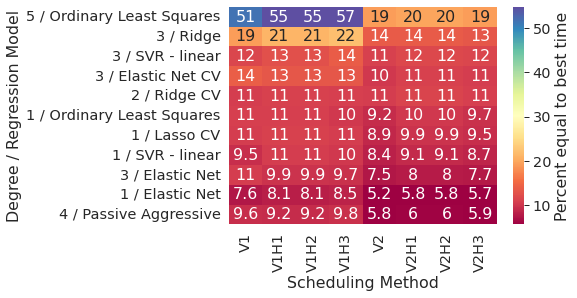

In [220]:
# normalize
total = 50_000
tmp = scoresDF.transform(lambda x: 100*x/total)
#
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in scoresDF.columns],
                 cbar_kws={"label":"Percent equal to best time"},
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
fig = ax.get_figure()
save_plot(fig, "heatmapBIS", bbox_inches="tight")
plt.show()

In [214]:
scores10PDF = pds.DataFrame(index=regModels, columns=methods, dtype=float)
for rm, s in regModelMethodScores10P.items():
    rM, meth = rm
    scores10PDF.loc[rM, meth] = s

In [215]:
scores10PDF

,recommenderV1,recommenderV1H1,recommenderV1H2,recommenderV1H3,recommenderV2,recommenderV2H1,recommenderV2H2,recommenderV2H3
5 / Ordinary Least Squares,43509.0,43304.0,43304.0,44438.0,37449.0,36687.0,36687.0,36050.0
3 / Ridge,42956.0,42587.0,42587.0,43463.0,37101.0,35902.0,35902.0,34888.0
3 / SVR - linear,38292.0,39259.0,39259.0,40567.0,35636.0,34450.0,34450.0,33553.0
3 / Elastic Net CV,38136.0,38746.0,38746.0,39246.0,34599.0,34365.0,34365.0,32863.0
2 / Ridge CV,37002.0,38431.0,38431.0,38518.0,35209.0,35127.0,35127.0,33285.0
1 / Ordinary Least Squares,33601.0,34683.0,34683.0,34709.0,33180.0,33224.0,33224.0,31051.0
1 / Lasso CV,35744.0,35850.0,35850.0,35905.0,32357.0,32831.0,32831.0,30720.0
1 / SVR - linear,33344.0,34826.0,34826.0,34813.0,32533.0,32668.0,32668.0,30441.0
3 / Elastic Net,34241.0,33357.0,33357.0,33455.0,30570.0,29937.0,29937.0,27852.0
1 / Elastic Net,30086.0,30887.0,30887.0,30790.0,27218.0,26728.0,26728.0,25694.0


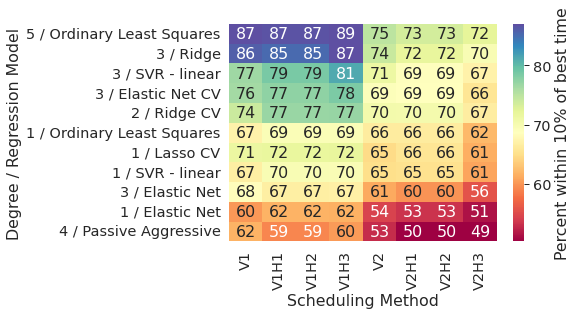

In [219]:
# normalize
total = 50_000
tmp = scores10PDF.transform(lambda x: 100*x/total)
#
ax = sns.heatmap(tmp,
                 cmap="Spectral",
                 xticklabels=[c.replace("recommender", "") for c in scoresDF.columns],
                 cbar_kws={"label":"Percent within 10% of best time"},
                 annot=True,
                 robust=True)
plt.xlabel("Scheduling Method")
plt.ylabel("Degree / Regression Model")
fig = ax.get_figure()
save_plot(fig, "heatmap10P", bbox_inches="tight")
plt.show()

# [END] trying out new visualisation

In [3]:
descByMethod = bigtable.groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByMethod.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# descByMethod

NameError: name 'bigtable' is not defined

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=descByMethod.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=bigtable,
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    save_plot(g, f"res_Vs_method_{style}.plot")
    plt.show()

In [ ]:
descByModel = bigtable[bigtable.regModel != "N/A"].groupby(["regModel"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByModel.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# descByModel

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=descByModel.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    save_plot(g, f"res_Vs_regModel_{style}.plot")
    plt.show()

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=descByModel.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"res_Vs_method_perWF_{style}.plot")
    plt.show()

# Filter for only the BiS regression model:

In [ ]:
bisModel = descByModel.index[0]
bigtable = bigtable.query("schedType == 'random' or regModel==@bisModel")

In [ ]:
descByMethodSansRand = bigtable[bigtable.regModel != "N/A"].groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
descByMethodSansRand.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=descByMethodSansRand.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=bigtable[bigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"res_Vs_method_bisModel_{style}.plot")
    plt.show()

In [ ]:
g = sns.catplot(x="wfName", y="res",  # orient="h",
                order=["eager", "methylseq", "sarek", "viralrecon", "chipseq"],
                hue="method",  # palette=["m", "g"],
                hue_order=["recommenderV1", "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2", "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # row="wfName",
                # col="wfName",
                # col_wrap=3,
                data=bigtable[bigtable.schedCat != "random"],
                kind="point",
                aspect=1.5,
                height=8,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="Strategy", frameon=False)
g.set(xlabel="Workflow", ylabel="Runtimes")
save_plot(g, "res_Vs_method_bisModel_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="schedCat",  # palette=["m", "g"],
                # row="wfName",
                col="wfName",
                col_wrap=3,
                col_order=list(wfNames),
                sharey=False,
                sharex=False,
                data=bigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45), title="Strategy Category", frameon=False)
for i, ax in enumerate(g.axes.ravel()):
    wf = list(wfNames)[i]
    ax.axhline(y=statistics.mean(bigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), linestyle="--", color="black")
g.set_titles("Workflow: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "res_Vs_clusterSize_perWF_bisModel_hueSchedCat_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="wfName",  # palette=["m", "g"],
                # row="wfName",
                col="schedType",
                col_wrap=3,
                col_order=["random", "recommenderV1", "recommenderV2",
                           "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # sharey=False,
                sharex=False,
                hue_order=list(wfNames),
                data=bigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, 1), ncol=5, title="Workflow", frameon=False)
for i, wf in enumerate(wfNames):
    g.refline(y=statistics.mean(bigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), color=sns.color_palette()[i])
g.set_titles("Strategy: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "res_Vs_clusterSize_perMethod_bisModel_hueWf_Point.plot")
plt.show()



In [ ]:
wfNames = cvBigtable.wfName.unique()

In [ ]:
sns.set_theme(style="whitegrid")
#sns.set_context("paper")
sns.set_context("paper", 1.65)

In [ ]:
pds.set_option('display.max_rows', 100)
pds.set_option('display.max_columns', None)
pds.set_option('display.width', None)
pds.set_option('display.precision', 4)

In [ ]:
cvDescByMethod = cvBigtable.groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByMethod.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# cvDescByMethod

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=cvDescByMethod.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=cvBigtable,
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    save_plot(g, f"res_Vs_method_{style}.plot")
    plt.show()

In [ ]:
cvDescByModel = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["regModel"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByModel.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)
# cvDescByModel

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=cvDescByModel.index,
                    hue="cvSplit",  # palette=["m", "g"],
                    # row="wfName",
                    # col="method",
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.5,
                    height=8
                    )
    sns.move_legend(g, "lower center", bbox_to_anchor=(0.5, 1), ncol=5, title="CV Split")
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    save_plot(g, f"cv.res_Vs_regModel_{style}.plot")
    plt.show()

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="regModel", orient="h",
                    order=cvDescByModel.index,
                    hue="cvSplit",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    sns.move_legend(g, "upper left", bbox_to_anchor=(0.75, 0.45), title="CV Split")
    g.set(xlabel="Runtimes", ylabel="Degree / Regression Model")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"cv.res_Vs_method_perWF_{style}.plot")
    plt.show()

# Filter for only the BiS regression model:

In [ ]:
# bisModel = descByModel.index[0]
comp = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["regModel", "cvSplit"])["res"].describe()
comp = comp.sort_values(by=["mean"], ascending=True)
rM, cvS = comp.reset_index().iloc[0][["regModel", "cvSplit"]]
cvBigtable = cvBigtable.query("schedType == 'random' or (regModel==@rM and cvSplit==@cvS)")

In [ ]:
cvDescByMethodSansRand = cvBigtable[cvBigtable.regModel != "N/A"].groupby(["method"])["res"].describe(  # percentiles=[x / 10 for x in range(1, 10)],
    include="all")
cvDescByMethodSansRand.sort_values(by=["mean"], axis=0, inplace=True, ascending=True)

In [ ]:
for style in ["Boxen"]:
    g = sns.catplot(x="res", y="method", orient="h",
                    order=cvDescByMethodSansRand.index,
                    # hue="wfName",  # palette=["m", "g"],
                    # row="wfName",
                    col="wfName",
                    col_wrap=3,
                    sharex=False,
                    data=cvBigtable[cvBigtable.regModel != "N/A"],
                    kind=style.lower(),
                    aspect=1.1,
                    height=6
                    )
    g.set(xlabel="Runtimes", ylabel="Strategy")
    g.set_titles("Workflow: {col_name}")
    save_plot(g, f"cv.res_Vs_method_bisModel_{style}.plot")
    plt.show()

In [ ]:
g = sns.catplot(x="wfName", y="res",  # orient="h",
                order=["eager", "methylseq", "sarek", "viralrecon", "chipseq"],
                hue="method",  # palette=["m", "g"],
                hue_order=["recommenderV1", "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2", "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # row="wfName",
                # col="wfName",
                # col_wrap=3,
                data=cvBigtable[cvBigtable.schedCat != "random"],
                kind="point",
                aspect=1.5,
                height=8,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.425, 1), ncol=4, title="Strategy", frameon=False)
g.set(xlabel="Workflow", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_method_bisModel_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="schedCat",  # palette=["m", "g"],
                # row="wfName",
                col="wfName",
                col_wrap=3,
                col_order=list(wfNames),
                sharey=False,
                sharex=False,
                data=cvBigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45), title="Strategy Category", frameon=False)
for i, ax in enumerate(g.axes.ravel()):
    wf = list(wfNames)[i]
    ax.axhline(y=statistics.mean(cvBigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), linestyle="--", color="black")
g.set_titles("Workflow: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_clusterSize_perWF_bisModel_hueSchedCat_Point.plot")
plt.show()

In [ ]:
g = sns.catplot(x="clusterSize", y="res",  # orient="h",
                # order="",
                hue="wfName",  # palette=["m", "g"],
                # row="wfName",
                col="schedType",
                col_wrap=3,
                col_order=["random", "recommenderV1", "recommenderV2",
                           "recommenderV1H1", "recommenderV1H2", "recommenderV1H3",
                           "recommenderV2H1", "recommenderV2H2", "recommenderV2H3"],
                # sharey=False,
                sharex=False,
                hue_order=list(wfNames),
                data=cvBigtable,
                kind="point",
                aspect=1.1,
                height=6,
                facet_kws=dict(legend_out=False)
                )
sns.move_legend(g, "lower center", bbox_to_anchor=(.45, 1), ncol=5, title="Workflow", frameon=False)
for i, wf in enumerate(wfNames):
    g.refline(y=statistics.mean(cvBigtable.query("method == 'randomV1P0' and wfName==@wf")["res"]), color=sns.color_palette()[i])
g.set_titles("Strategy: {col_name}")
g.set(xlabel="Cluster size", ylabel="Runtimes")
save_plot(g, "cv.res_Vs_clusterSize_perMethod_bisModel_hueWf_Point.plot")
plt.show()
